In [2]:
import numpy as np
import os
from keras.layers import Conv3D, MaxPooling3D
from keras.layers import Dense, Dropout, Flatten
from keras.models import Sequential
from keras.layers import Activation, ZeroPadding3D, TimeDistributed, LSTM, GRU, Reshape
#from keras.utils import plot_model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import gc
from sklearn.metrics import classification_report, balanced_accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.preprocessing import LabelEncoder
import sklearn
import seaborn as sns
import tensorflow as tf
from keras import regularizers
from tensorflow.keras.utils import to_categorical
from prettytable import PrettyTable
from matplotlib import pyplot as plt
import cv2
from sklearn.model_selection import KFold
import time

# Noise Reduction 

In [5]:
import cv2
import os

def reduce_noise(input_folder, output_folder):
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Loop through each file in the input folder
    for filename in os.listdir(input_folder):
        if filename.endswith(".mp4"):  # Assuming all files are videos
            video_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, filename)

            # Open the video file
            cap = cv2.VideoCapture(video_path)
            frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
            fps = int(cap.get(cv2.CAP_PROP_FPS))

            # Create VideoWriter object
            fourcc = cv2.VideoWriter_fourcc(*'mp4v')
            out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

            # Process each frame
            for _ in range(frame_count):
                ret, frame = cap.read()
                if ret:
                    # Apply Gaussian blur for noise reduction
                    blurred_frame = cv2.GaussianBlur(frame, (5, 5), 0)
                    out.write(blurred_frame)

            # Release resources
            cap.release()
            out.release()

            print(f"Noise reduction completed for {filename}")

# Example usage:
input_folder = "D:\\FINAL MAJOR20-2\\Dataset1.0"
output_folder = "D:\\FINAL MAJOR20-2\\Noise reduction\\output"
reduce_noise(input_folder, output_folder)


Noise reduction completed for a.mp4
Noise reduction completed for bye.mp4
Noise reduction completed for can.mp4
Noise reduction completed for cat.mp4
Noise reduction completed for demo.mp4
Noise reduction completed for dog.mp4
Noise reduction completed for hello.mp4
Noise reduction completed for here.mp4
Noise reduction completed for is.mp4
Noise reduction completed for lips.mp4
Noise reduction completed for my.mp4
Noise reduction completed for read.mp4
Noise reduction completed for you.mp4


# Converting to Frames

In [6]:
import os
import cv2

def extract_frames(video_folder, output_folder, num_frames=8):
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Iterate through each video file in the folder
    for filename in os.listdir(video_folder):
        if filename.endswith(".mp4") or filename.endswith(".avi"):
            video_path = os.path.join(video_folder, filename)
            video_name = os.path.splitext(filename)[0]

            # Create a subfolder for each video
            video_output_folder = os.path.join(output_folder, video_name)
            if not os.path.exists(video_output_folder):
                os.makedirs(video_output_folder)

            # Open the video file
            cap = cv2.VideoCapture(video_path)

            # Get the total number of frames in the video
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

            # Calculate the frame interval to get exactly num_frames frames
            frame_interval = max(1, total_frames // num_frames)

            frame_count = 0

            # Read and process each frame
            while(cap.isOpened() and frame_count < num_frames):
                ret, frame = cap.read()
                if not ret:
                    break

                # Save the frame
                output_frame_path = os.path.join(video_output_folder, f"{video_name}_frame_{frame_count}.jpg")
                cv2.imwrite(output_frame_path, frame)

                frame_count += 1

                # Move to the next frame based on the calculated interval
                cap.set(cv2.CAP_PROP_POS_FRAMES, frame_count * frame_interval)

            cap.release()

# Example usage:
video_dataset_folder = "D:\\FINAL MAJOR20-2\\Noise reduction\\output"
output_frames_folder = "D:\\FINAL MAJOR20-2\\Frames"
extract_frames(video_dataset_folder, output_frames_folder, num_frames=8)


# Converting Normal Frames into GLCM

In [7]:
import os
import cv2
import numpy as np
from skimage.feature import graycomatrix, graycoprops

def glcm_noise_reduction(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Compute the GLCM of the grayscale image
    glcm = graycomatrix(gray, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4])

    # Compute the mean of the GLCM
    mean_glcm = np.mean(glcm)

    # Subtract the mean from the original image to reduce noise
    reduced_noise_image = gray - mean_glcm

    return reduced_noise_image

# Specify the directory containing the folders with frames
root_dir = "D:\\FINAL MAJOR20-2\\Frames"

# Create a new folder to save all the noise-reduced images
new_root_dir = "D:\\FINAL MAJOR20-2\\output_denoised_image_folder"

# Loop over each folder (video)
for folder in os.listdir(root_dir):
    folder_path = os.path.join(root_dir, folder)
    new_folder_path = os.path.join(new_root_dir, folder)
    os.makedirs(new_folder_path, exist_ok=True)

    # Loop over each image (frame) in the folder
    for frame in os.listdir(folder_path):
        frame_path = os.path.join(folder_path, frame)

        # Read the image
        image = cv2.imread(frame_path)

        # Apply GLCM noise reduction
        reduced_noise_image = glcm_noise_reduction(image)

        # Save the noise-reduced image in the new folder
        cv2.imwrite(os.path.join(new_folder_path, frame), reduced_noise_image)

print('Noise reduction completed.')


Noise reduction completed.


# GLCM


In [4]:
import os
import imageio
import numpy as np
from skimage.feature import graycomatrix, graycoprops
from skimage import io
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten
from tensorflow.keras.callbacks import Callback
from sklearn.model_selection import train_test_split

# Constants
IMAGE_SIZE = (112, 80)
NUM_CLASSES = 13
PATCH_SIZE = 35

# Load dataset
dataset_dir = "D:/FINAL MAJOR20-2/GLCM-LSTM/kaggleDataset/output_denoised_image_folder"
class_folders = os.listdir(dataset_dir)
classes = {class_name: i for i, class_name in enumerate(class_folders)}
num_samples = sum(len(os.listdir(os.path.join(dataset_dir, class_name))) for class_name in class_folders)


In [8]:
from sklearn.model_selection import KFold
import time

# Define number of folds
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize arrays to store features and labels
X = np.zeros((num_samples, 6))  # 6 GLCM properties per patch
y = np.zeros((num_samples, NUM_CLASSES))

# Extract GLCM features for each image frame
index = 0
for class_name in class_folders:
    class_dir = os.path.join(dataset_dir, class_name)
    for image_file in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_file)
        image = imageio.imread(image_path)
        # Resize image to required size
        image = cv2.resize(image, IMAGE_SIZE)
        # Compute GLCM
        GLCM = graycomatrix(image, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4])
        features = []
        for prop in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']:
            features.append(graycoprops(GLCM, prop)[0, 0])
        X[index] = np.array(features)
        y[index, classes[class_name]] = 1
        index += 1

# Save GLCM features (optional)
np.save('GLCM_features_Kfold.npy', X)

    # Build LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(1, 6)))  # Input shape is (1, 6) for each patch
model.add(Dense(NUM_CLASSES, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


train_accuracy_list = []
val_accuracy_list = []
comp_times = []

fold_index = 1

#startTime
start_time = time.time()

for train_index, val_index in kfold.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Reshape input data for LSTM
    X_train = np.expand_dims(X_train, axis=1)
    X_val = np.expand_dims(X_val, axis=1)

    # Train the model
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[AccuracyCallback()])

    train_accuracy_list.append(history.history['accuracy'][-1])
    val_accuracy_list.append(history.history['val_accuracy'][-1])
    comp_times.append(time.time() - start_time)

    # Save the model
    model.save(f'GLCM_LSTM_fold{fold_index}.h5')
    fold_index += 1

# Track end time
end_time = time.time()

# Calculate average training and validation accuracy
avg_train_accuracy = np.mean(train_accuracy_list)
avg_val_accuracy = np.mean(val_accuracy_list)

print(f'Average Training Accuracy: {avg_train_accuracy * 100:.2f}%')
print(f'Average Validation Accuracy: {avg_val_accuracy * 100:.2f}%')
print("Average Training Time:", np.mean(comp_times))
print("Total Training Time:", end_time - start_time)

C:\Users\sumit\AppData\Local\Temp\ipykernel_13116\2789536662.py:18: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_path)


Epoch 1/100
3/3 [==============================] - 2s 215ms/step - loss: 2.6235 - accuracy: 0.0602 - val_loss: 2.7195 - val_accuracy: 0.0476
Epoch 2/100
3/3 [==============================] - 0s 17ms/step - loss: 2.5943 - accuracy: 0.0482 - val_loss: 2.7087 - val_accuracy: 0.0476
Epoch 3/100
3/3 [==============================] - 0s 17ms/step - loss: 2.5787 - accuracy: 0.0482 - val_loss: 2.7018 - val_accuracy: 0.0476
Epoch 4/100
3/3 [==============================] - 0s 17ms/step - loss: 2.5661 - accuracy: 0.0723 - val_loss: 2.7008 - val_accuracy: 0.0000e+00
Epoch 5/100
3/3 [==============================] - 0s 27ms/step - loss: 2.5582 - accuracy: 0.0723 - val_loss: 2.7010 - val_accuracy: 0.0000e+00
Epoch 6/100
3/3 [==============================] - 0s 41ms/step - loss: 2.5551 - accuracy: 0.1084 - val_loss: 2.7019 - val_accuracy: 0.0000e+00
Epoch 7/100
3/3 [==============================] - 0s 38ms/step - loss: 2.5529 - accuracy: 0.0964 - val_loss: 2.7038 - val_accuracy: 0.0000e+00
Epo

In [12]:
print(f'Average Training Accuracy: {avg_train_accuracy*100}%')
print(f'Average Validation Accuracy: {avg_val_accuracy*100}%')

Average Training Accuracy: 14.185312837362291%
Average Validation Accuracy: 4.809523895382881%


# Training accuracy

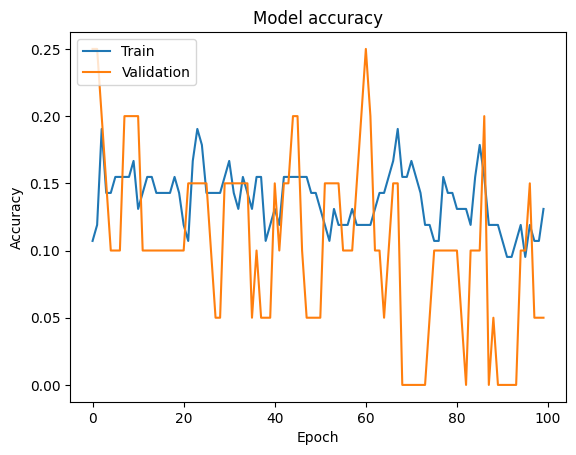

In [10]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# ROC CURVE

c:\Users\sumit\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


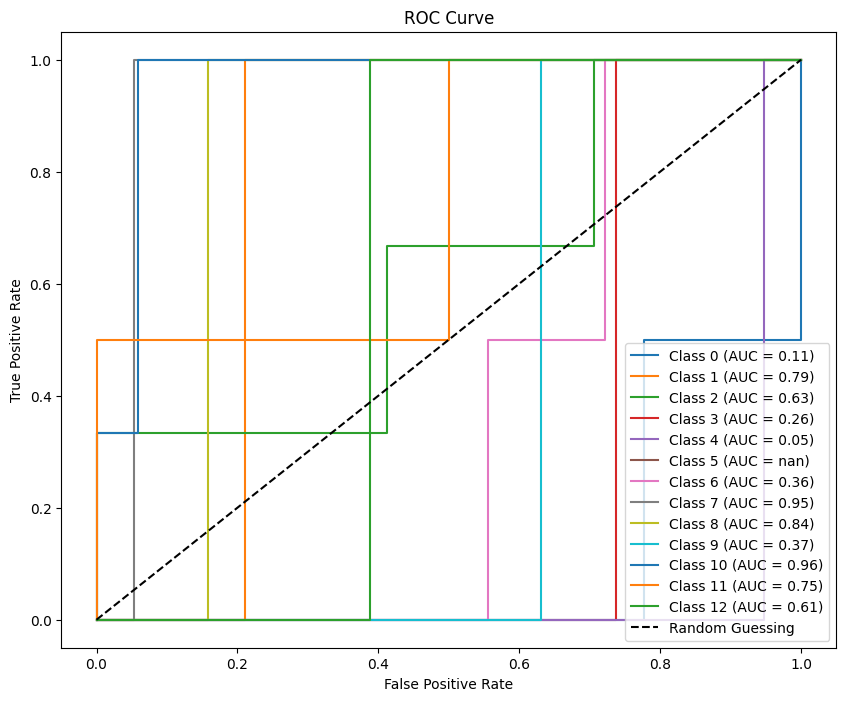

In [25]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have trained your model
# Get predictions on validation data
y_pred = model.predict(X_val)
y_true = y_val

# Convert y_true to single label format
y_true_single = np.argmax(y_true, axis=1)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve((y_true_single == i).astype(int), y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(NUM_CLASSES):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()



# Confusion Matrix

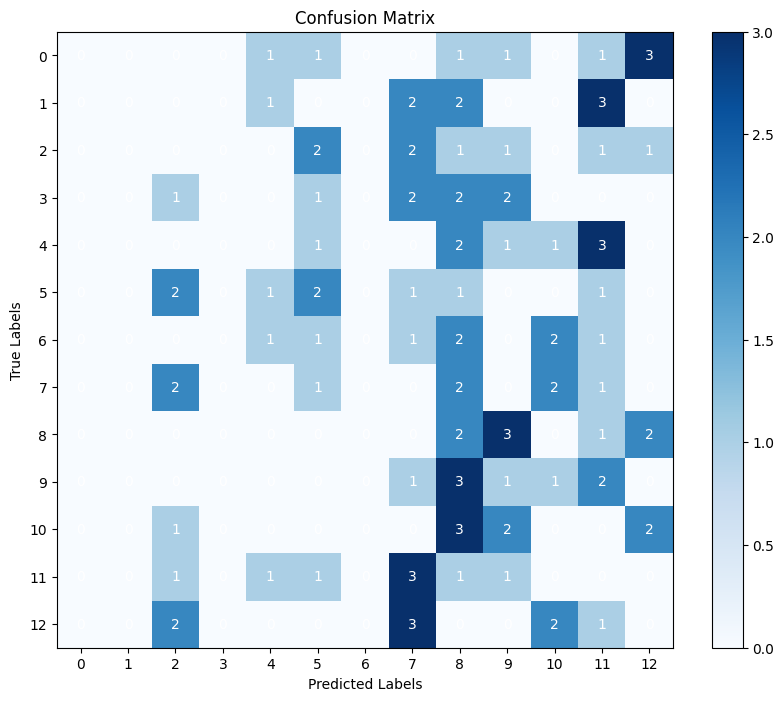

In [18]:
from sklearn.metrics import confusion_matrix
from keras.models import load_model

# Initialize arrays to store predictions and true labels
y_true_all = []
y_pred_all = []

fold_index = 1
for train_index, val_index in kfold.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Reshape input data for LSTM
    X_train = np.expand_dims(X_train, axis=1)
    X_val = np.expand_dims(X_val, axis=1)

    # Load the trained model for the current fold
    model = load_model(f'GLCM_LSTM_fold{fold_index}.h5')

    # Get predictions on validation data
    y_pred = model.predict(X_val)
    y_true = y_val

    # Convert y_true to single label format
    y_true_single = np.argmax(y_true, axis=1)
    y_pred_single = np.argmax(y_pred, axis=1)

    y_true_all.extend(y_true_single)
    y_pred_all.extend(y_pred_single)

    fold_index += 1

# Calculate confusion matrix
cm = confusion_matrix(y_true_all, y_pred_all)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(np.arange(NUM_CLASSES))
plt.yticks(np.arange(NUM_CLASSES))
for i in range(NUM_CLASSES):
    for j in range(NUM_CLASSES):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.show()


In [24]:
from sklearn.metrics import precision_recall_fscore_support
from prettytable import PrettyTable
import pandas as pd
import numpy as np

# Initialize lists to store metrics for each fold and each class
train_precisions = [[] for _ in range(NUM_CLASSES)]
train_recalls = [[] for _ in range(NUM_CLASSES)]
train_f1_scores = [[] for _ in range(NUM_CLASSES)]
train_supports = [[] for _ in range(NUM_CLASSES)]
val_precisions = [[] for _ in range(NUM_CLASSES)]
val_recalls = [[] for _ in range(NUM_CLASSES)]
val_f1_scores = [[] for _ in range(NUM_CLASSES)]
val_supports = [[] for _ in range(NUM_CLASSES)]

fold_index = 1
for train_index, val_index in kfold.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Reshape input data for LSTM
    X_train = np.expand_dims(X_train, axis=1)
    X_val = np.expand_dims(X_val, axis=1)

    # Load the trained model for the current fold
    model = load_model(f'GLCM_LSTM_fold{fold_index}.h5')

    # Get predictions on training and validation data
    train_predictions = model.predict(X_train)
    val_predictions = model.predict(X_val)

    # Convert predictions to class labels
    train_pred_labels = np.argmax(train_predictions, axis=1)
    val_pred_labels = np.argmax(val_predictions, axis=1)

    # Calculate metrics for training and validation data for each class
    for class_idx in range(NUM_CLASSES):
        train_precision, train_recall, train_f1_score, train_support = precision_recall_fscore_support(
            np.argmax(y_train, axis=1), train_pred_labels, labels=[class_idx], average='macro', zero_division=1)
        val_precision, val_recall, val_f1_score, val_support = precision_recall_fscore_support(
            np.argmax(y_val, axis=1), val_pred_labels, labels=[class_idx], average='macro', zero_division=1)

        train_precisions[class_idx].append(train_precision)
        train_recalls[class_idx].append(train_recall)
        train_f1_scores[class_idx].append(train_f1_score)
        train_supports[class_idx].append(train_support)

        val_precisions[class_idx].append(val_precision)
        val_recalls[class_idx].append(val_recall)
        val_f1_scores[class_idx].append(val_f1_score)
        val_supports[class_idx].append(val_support)

    fold_index += 1

# Calculate average metrics for each class
avg_train_precisions = [np.mean([prec for prec in precisions if prec is not None]) for precisions in train_precisions]
avg_train_recalls = [np.mean([rec for rec in recalls if rec is not None]) for recalls in train_recalls]
avg_train_f1_scores = [np.mean([f1 for f1 in f1_scores if f1 is not None]) for f1_scores in train_f1_scores]
avg_train_supports = [np.mean([sup for sup in supports if sup is not None]) for supports in train_supports]

avg_val_precisions = [np.mean([prec for prec in precisions if prec is not None]) for precisions in val_precisions]
avg_val_recalls = [np.mean([rec for rec in recalls if rec is not None]) for recalls in val_recalls]
avg_val_f1_scores = [np.mean([f1 for f1 in f1_scores if f1 is not None]) for f1_scores in val_f1_scores]
avg_val_supports = [np.mean([sup for sup in supports if sup is not None]) for supports in val_supports]


# Create PrettyTable for average training metrics
train_table = PrettyTable()
train_table.field_names = ["Class", "Precision", "Recall", "F1 Score", "Support"]
for class_idx in range(NUM_CLASSES):
    train_table.add_row([class_idx, avg_train_precisions[class_idx], avg_train_recalls[class_idx],
                         avg_train_f1_scores[class_idx], avg_train_supports[class_idx]])

# Create PrettyTable for average validation metrics
val_table = PrettyTable()
val_table.field_names = ["Class", "Precision", "Recall", "F1 Score", "Support"]
for class_idx in range(NUM_CLASSES):
    val_table.add_row([class_idx, avg_val_precisions[class_idx], avg_val_recalls[class_idx],
                       avg_val_f1_scores[class_idx], avg_val_supports[class_idx]])

# Print tables
print("Average Training Metrics:")
print(train_table)
print("\nAverage Validation Metrics:")
print(val_table)

# Create DataFrames for average training and validation metrics
train_df = pd.DataFrame({
    'Class': range(NUM_CLASSES),
    'Precision': avg_train_precisions,
    'Recall': avg_train_recalls,
    'F1 Score': avg_train_f1_scores,
    'Support': avg_train_supports
})

val_df = pd.DataFrame({
    'Class': range(NUM_CLASSES),
    'Precision': avg_val_precisions,
    'Recall': avg_val_recalls,
    'F1 Score': avg_val_f1_scores,
    'Support': avg_val_supports
})

# Concatenate DataFrames
combined_df = pd.concat([train_df, val_df], ignore_index=True)

# Save combined DataFrame to an Excel sheet
combined_excel_path = 'average_metrics.xlsx'
combined_df.to_excel(combined_excel_path, index=False)

print(f"Average metrics saved to {combined_excel_path}")


Average Training Metrics:
+-------+---------------------+---------------------+---------------------+---------+
| Class |      Precision      |        Recall       |       F1 Score      | Support |
+-------+---------------------+---------------------+---------------------+---------+
|   0   |         1.0         |         0.0         |         0.0         |   nan   |
|   1   |         1.0         |         0.0         |         0.0         |   nan   |
|   2   |  0.6866666666666666 | 0.14166666666666666 | 0.09824561403508772 |   nan   |
|   3   |         0.4         |         0.0         |         0.0         |   nan   |
|   4   |  0.8400000000000001 | 0.08571428571428572 | 0.05454545454545454 |   nan   |
|   5   |  0.5462121212121211 |  0.3107142857142857 | 0.19583333333333333 |   nan   |
|   6   |         1.0         |         0.0         |         0.0         |   nan   |
|   7   |  0.6355555555555557 | 0.12857142857142856 | 0.05454545454545454 |   nan   |
|   8   |  0.329597147950089

c:\Users\sumit\anaconda3\envs\tf\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\sumit\anaconda3\envs\tf\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [67]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Create an ImageDataGenerator object
# datagen = ImageDataGenerator(rescale=1./255)

# # Create a generator
# generator = datagen.flow_from_directory(
#     'D:\\New Dataset Lip Movement Projec\\FINAL YEAR PROJECT\\output_denoised_image_folder',
#     target_size=(150, 150),
#     batch_size=16,
#     class_mode='binary'
# )

# print(generator.batch_size)


Found 298 images belonging to 17 classes.
16
